# IRT Solver: How to get a Reasonable Solution?
* We assume that each item measures the same single scale (scalar $\theta$).
* There are many solutions; we want to minimize a functional that will give a reasonable result. To this end, we pick

$$ L(\theta) := \frac{1}{P I} \sum_{p=1}^P \sum_{i=I}^I (P_i(\theta_p) - x_{pi} ) ^2, $$

with $P_i$ being a linear interpolant from a grid of bins $\left\{B_j\right\}_{j=1}^n$ from the bin central values $P_{ij} = \sum_{p \in B_j} x_{pi} / |B_j|$. This completely defines the functional as a function of $\theta$ only.

where $x_{pi}$ is the response of student $p$ to item $I$, $p = 1,\dots,P$, $i = 1,\dots,I$. $x_{pi}$ is continuous in $[0,1]$.

### Synthetic data
To test our non-parametric IRT model, we generate $20$ items with a parameteric form $P_i(\theta) = 1 / (1 + e^{-a_i(\theta - b_i)}$. $a_i = 1$ and $b_i$ were chosen as a uniform grid over $[-3,3]$.

A sample $1000$ student abilities $\theta_p$ was drawn from the prior distribution (normal) assumed in IRT literature. From that we can compute $x_{pi}$.

### Results
* When $x_{pi}$ is continuous ($=P_i(\theta_p)$ for the exact $\theta, P_i$), we obtain a solution very close to the exact solution, except for very large or very small $\theta$, which are all ``squashed'' to the same $\theta$ value. That's because $L$ is flat in this region: $P_i$ is nearly $0$ or nearly $1$, respectively, so such a $\theta_p$ can assume any value without changing the loss.
* Thus, I tried to transform first the problem from probabilities into log-odds, i.e.,

$$ \tilde{L}(\theta) := \frac{1}{P I} \sum_{p=1}^P \sum_{i=I}^I (logit(P_i(\theta_p)) - logit(x_{pi}) ) ^2. $$

where $logit(t) = log(t / (1-t))$, and this time we interpolate $logit(P_i)$ from its bin values.

Here we get a much better result for small and large $\theta$; but that's also because for the exact solution, it happens that $logit(P_i)$ is linear, so it is reproduced exactly with a linear interpolant. But maybe it's a generally good idea to work with the logit, as it is much smoother.

* When $x_{pi}$ becomes discrete, however, e.g., $Binomial(m, P_i(\theta_p))$, even for large $m$ we obtain a much worse result. (Here we are viewing the method as being applied to finding the abilities of groups of students of size $m$.) Furthermore, nothing prevents $x_{pi}$ from being $0$ or $1$, when working with the logit yields infinite values.

In [93]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import cntree.cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_item_clustering
import nirt.solver_refinement
import numpy as np
import numpy.matlib
import sklearn.metrics
import scipy.optimize
from numpy.linalg import norm, svd
from scipy.special import logit

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

np.set_printoptions(precision=3, linewidth=1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

# Binary or continuous students responses.
dichotomous = False

# Type of loss function.
loss = "l2" #"l2_logit"
use_logit = False # True

In [106]:
def initial_guess(X, use_logit):
    Y = logit(X) if use_logit else X
    theta = nirt.likelihood.initial_guess(X, c)
    return (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)

def print_run_log(theta_exact, model_irf, theta_init, recorder):
    # Run history: calculate the IRF error from the known parametric model.
    logger.info("Initial guess / score-based estimation correlation: {:.3f}".format(
        np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))
    coarsest_resolution = len(list(recorder.irf.values())[0][0][0].count)
    
    for k, (resolution, value) in enumerate(recorder.irf.items()):
        logger.info("#items {}".format(resolution))
        level = solver._clustering[k]
        cluster_model_irf = [
            lambda t, i=i: np.array([model_irf[j](t) for j in level[i]]).mean(0) 
            for i in range(resolution)]
        x = np.array([X[:, cluster].mean(1) for cluster in level]).transpose()

        numerical_irf = solver._update_irf(coarsest_resolution, theta_init, x=logit(x) if use_logit else x)
        l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(theta_init, use_logit=use_logit)
        logger.info("Initial guess loss {:.7f}".format(l2_loss))

        for j in range(len(value)):
            numerical_irf = value[j]
            e = nirt.error.error_norm_by_item(cluster_model_irf, numerical_irf)
            t = recorder.theta[resolution][j]
            l2_loss = nirt.likelihood.Likelihood(x, c, numerical_irf).l2_loss(t, use_logit=use_logit)
            logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.3f}, {:.3f} corr {:3f} loss {:.7f}".format(
                e.mean(), e.std(), t.min(), t.max(), 
                np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1], l2_loss))
            
def plot_multilevel_irfs(recorder, model_irf, plot_last=False):
    # For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
    # quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
    inactive = np.arange(P, dtype=int)
    active = np.array([], dtype=int)

#    xlim = [(min(theta[:, ci])-1, max(theta[:, ci])+1) for ci in range(C)]
#    grid_all = [nirt.grid.create_grid(theta[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]

    item_levels = list(recorder.irf.keys())
    for k, num_items in enumerate(item_levels):
        if num_items < 4:
            fig, axs = plt.subplots(1, num_items, figsize=(8, 4))
        else:
            fig, axs = plt.subplots(num_items // 4, 4, figsize=(12, 0.5 * num_items))
        cluster = solver._clustering[k]

        for i in range(num_items):
            ax = axs[i // 4, i % 4] if num_items > 4 else (axs[i] if num_items > 1 else axs)
            colors = ["red", "green", "purple", "orange"]
            cluster_model_irf = lambda t: np.array([model_irf[j](t) for j in cluster[i]]).mean(0)
            nirt.simulate.plot_irf.plot_model_irf(
                ax, recorder.irf[num_items][-1][i].grid, cluster_model_irf, color="blue", label="Original",
                use_logit=use_logit)
            for l, irf in enumerate(recorder.irf[num_items][-1:] if plot_last else recorder.irf[num_items]):
                irf[i].plot(ax, color=colors[l % len(colors)], point_color="r",
                            label="iter {} Error {:.2f}".format(
                                l, nirt.error.error_norm(cluster_model_irf, irf[i])),
                            use_logit=use_logit, xlim=None)
            ax.set_title("Item {}".format(i))
            ax.grid(True)
            #ax.legend()
            
def compare_theta_scatter(theta_exact, theta_init, t):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    ax = axs[0, 0]
    ax.hist(theta_exact, 100);
    ax.hist(theta_init[:, 0], 100);
    ax.set_title("Initial guess / score-based")


    ax = axs[0, 1]
    ax.hist(theta_exact, 100);
    ax.hist(t[:, 0], 100);
    ax.set_title(r"Final $\theta$");

    ax = axs[1, 0]
    ax.scatter(theta_exact[:, 0], theta_init[:, 0], marker='.');
    ax.set_xlim([-3, 3]);
    ax.set_ylim([-3, 3]);
    ax.set_title("Initial guess / score-based corr {:.5f}".format(
        np.corrcoef(theta_exact[:, 0], theta_init[:, 0])[0, 1]))
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\hat{\theta}$")
    ax.grid(True);

    ax = axs[1, 1]
    ax.scatter(theta_exact[:, 0], t[:, 0], marker='.');
    ax.set_xlim([-3, 3]);
    ax.set_ylim([-3, 3]);
    ax.set_title(r"Final $\theta$, corr {:.5f}".format(
        np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\hat{\theta}$")
    ax.grid(True);

## Continuous Responses
First, verify that we can reconstruct the exact solution when $X_{pi} = P_i(\theta_p)$.

In [96]:
# # Generate synthetic data.
# X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination, dichotomous=dichotomous)
# if use_logit:
#     model_irf = [lambda t,i=i: logit(nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)) for i in range(I)]
# else:
#     model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
    
# # Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# ax = axs[0]
# ax.hist(theta_exact[:, 0], 100)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel('Frequency')
# ax.set_title(r"\theta$ exact distribution, P = {}".format(P))

# ax = axs[1]
# ax.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
# ax.scatter(range(I), b, label="b")
# ax.set_xlabel("Item number $i$")
# ax.set_ylabel("Probability of person success on $X(:,i)$")
# ax.legend();
# ax.grid(True);

<!-- ### Check Solution Consistency
We assume that the center of the bin is the mean of $P_i(\theta)$ over the bin. This is appoximately true for any smooth IRF, but not exact. For a bin of size $h$, the error is $O(h^2)$. -->

In [97]:
# A, B = discrimination, b[5]
# print("a", A, "b", B)

# t = np.linspace(-5, 5, 100)
# plt.plot(t, model_irf[5](t))
# plt.grid(True);

# # Print some (t1,t2) intervals, the exact 2PL model's central value, bin average (exact integral),
# # and differrence. As resolution n increases, this is an O(n^(-2)) difference.
# for n in 2 ** np.arange(2, 6):
#     bins = np.linspace(-5, 5, n + 1)
#     mean_error = np.mean([
#         np.abs(1 + np.log((np.exp(-A*(t2-B)) + 1) / (np.exp(-A*(t1-B)) + 1)) / (A * (t2 - t1)) - 
#                1 / (1 + np.exp(-A*(0.5*(t1+t2)-B))))
#         for t1, t2 in zip(bins[:-1], bins[1:])])
#     print("n {:3d} mean error {:.2e}".format(n, mean_error))

<!-- ### Item Clustering -->

In [98]:
# bin_size = P // 50
# x_coarse = X[nirt.irf.sorted_chunks(X, bin_size)].mean(1)
# tree = cntree.cntree.CNTree(debug=1)
# clustering = tree.cluster(x_coarse.transpose())
# for level in [level for level in cntree.cntree.get_clustering_levels(clustering) if level.size <= 0.5 * I]:
#     print(level, level.label)

### Loss $L$ in terms of $P_i(\theta)$ 
This is a Subscale + IRF Resolution Refinement Solver: refining the item cluster resolution and the IRFs at the same time during continuation steps.

In [99]:
use_logit = False
num_trials = None
dichotomous = False
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination, dichotomous=dichotomous, num_trials=num_trials)
if use_logit:
    model_irf = [lambda t,i=i: logit(nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)) for i in range(I)]
else:
    model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("X range", X.min(), X.max())
print("theta exact mean", np.mean(theta_exact, axis=0), "std", np.std(theta_exact, axis=0))

X range 0.0034723355769420727 0.9991827048381505
theta exact mean [-0.048] std [1.004]


In [100]:
# Run iterative refinement algorithm.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=2, num_theta_sweeps=0, grid_method="quantile",
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss, alpha=0.0, refine_irf=True, use_logit=False)

t = solver.solve()

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.5    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	18   	1.11   	1.1    	0.3    	0.01
INFO     Total						0.02
INFO     Trimming #neighbors to 5
INFO     Initial guess range [-2.43, 3.27] mean -0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 2 items 8 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 4 items 16 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 8 items 32 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 20 items 64 bins
INFO     Iteration 1/2
INFO     Iteration 2/2


INFO     Initial guess / score-based estimation correlation: 0.999
INFO     #items 1
INFO     Initial guess loss 0.0009533
INFO     IRF error: 0.053 +- 0.000	t range -2.434, 3.267 corr 0.998992 loss 0.0009533
INFO     IRF error: 0.029 +- 0.000	t range -2.040, 2.451 corr 0.973351 loss 0.0011932
INFO     #items 2
INFO     Initial guess loss 0.0011262
INFO     IRF error: 0.017 +- 0.001	t range -1.881, 2.522 corr 0.985111 loss 0.0021125
INFO     IRF error: 0.022 +- 0.009	t range -1.836, 2.539 corr 0.985046 loss 0.0007011
INFO     #items 4
INFO     Initial guess loss 0.0014530
INFO     IRF error: 0.019 +- 0.002	t range -1.817, 2.545 corr 0.986319 loss 0.0006535
INFO     IRF error: 0.021 +- 0.002	t range -1.797, 2.580 corr 0.985603 loss 0.0002817
INFO     #items 8
INFO     Initial guess loss 0.0015411
INFO     IRF error: 0.021 +- 0.003	t range -1.786, 2.569 corr 0.986857 loss 0.0002071
INFO     IRF error: 0.022 +- 0.003	t range -1.790, 2.584 corr 0.987238 loss 0.0000996
INFO     #items 20
IN

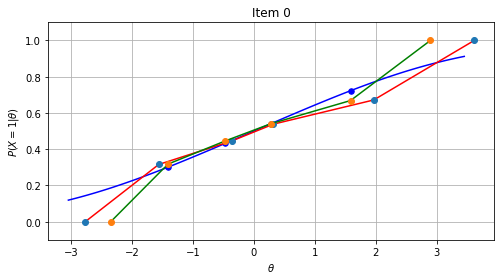

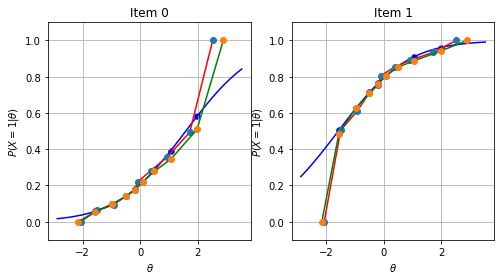

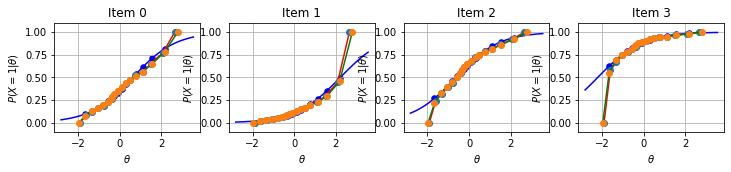

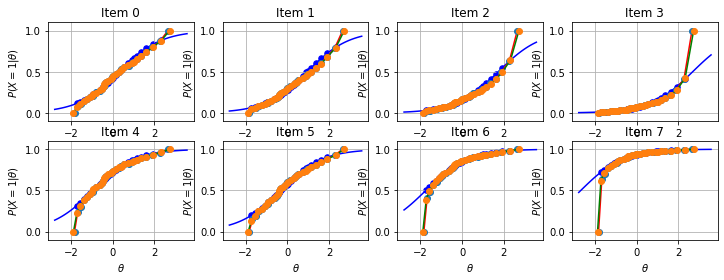

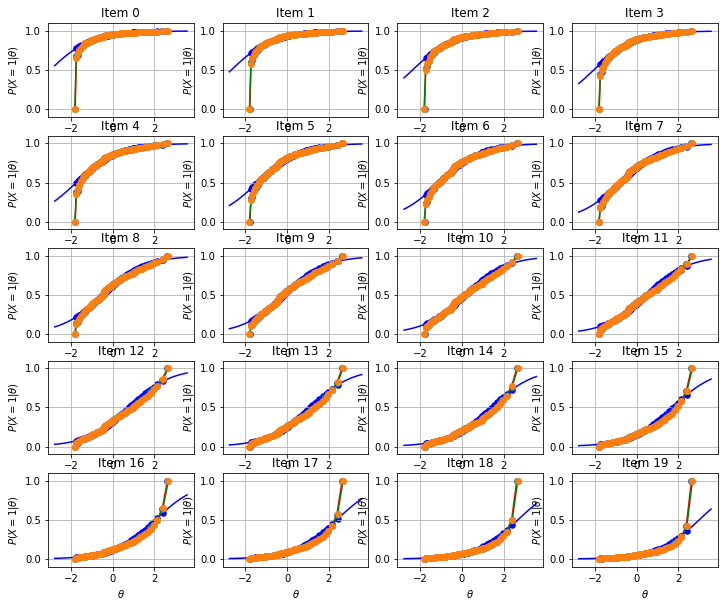

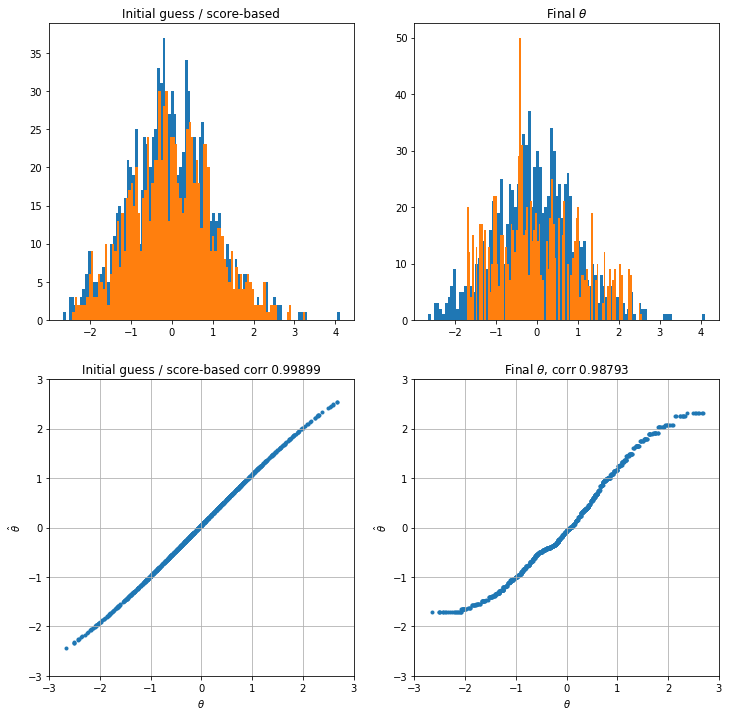

In [101]:
theta_init = initial_guess(X, use_logit)
print_run_log(theta_exact, model_irf, theta_init, recorder)
plot_multilevel_irfs(recorder, model_irf)
compare_theta_scatter(theta_exact, theta_init, t)

Note how the lowest and highest $\theta$s are assigned the same value since our loss is flat there.

### Loss $L$ in terms of $logit(P_i(\theta))$ 

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.5    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	18   	1.11   	1.1    	0.3    	0.00
INFO     Total						0.02
INFO     Trimming #neighbors to 5
INFO     Initial guess range [-2.96, 2.96] mean 0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/2


X range 0.0017844301977704862 0.9981864974754565
theta exact mean [-0.004] std [0.976]


INFO     Iteration 2/2
INFO     Solving at item clustering level with 2 items 8 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 4 items 16 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 8 items 32 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Solving at item clustering level with 20 items 64 bins
INFO     Iteration 1/2
INFO     Iteration 2/2
INFO     Initial guess / score-based estimation correlation: 0.999
INFO     #items 1
INFO     Initial guess loss 0.0553121
INFO     IRF error: 1.281 +- 0.000	t range -2.962, 2.960 corr 0.999281 loss 0.4888137
INFO     IRF error: 1.083 +- 0.000	t range -2.261, 2.273 corr 0.974774 loss 0.4601965
INFO     #items 2
INFO     Initial guess loss 0.1312943
INFO     IRF error: 1.573 +- 0.397	t range -2.374, 2.249 corr 0.987508 loss 2.0149592
INFO     IRF error: 1.645 +- 0.404	t range -2.398, 2.277 corr 0.987933 loss 2.0300753
INFO     #items 4


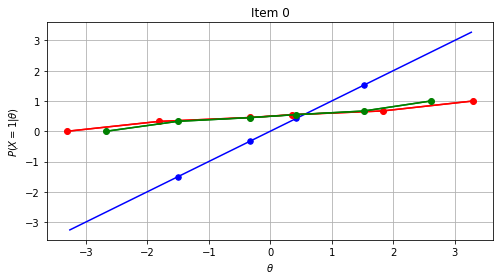

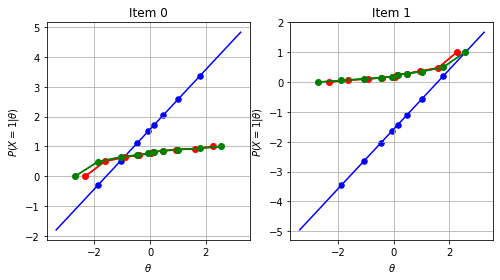

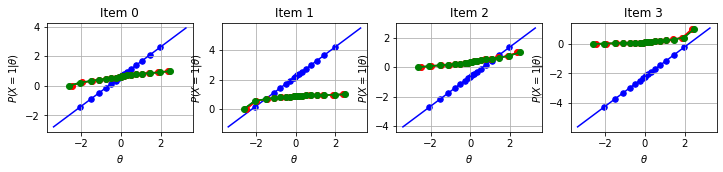

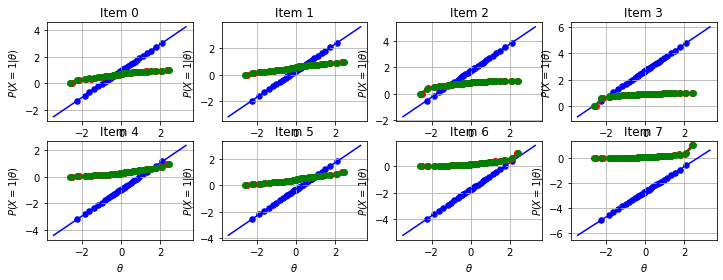

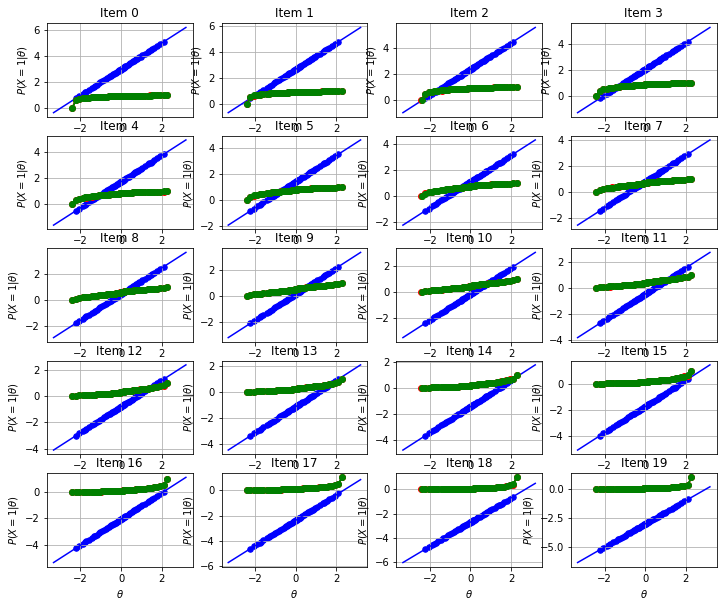

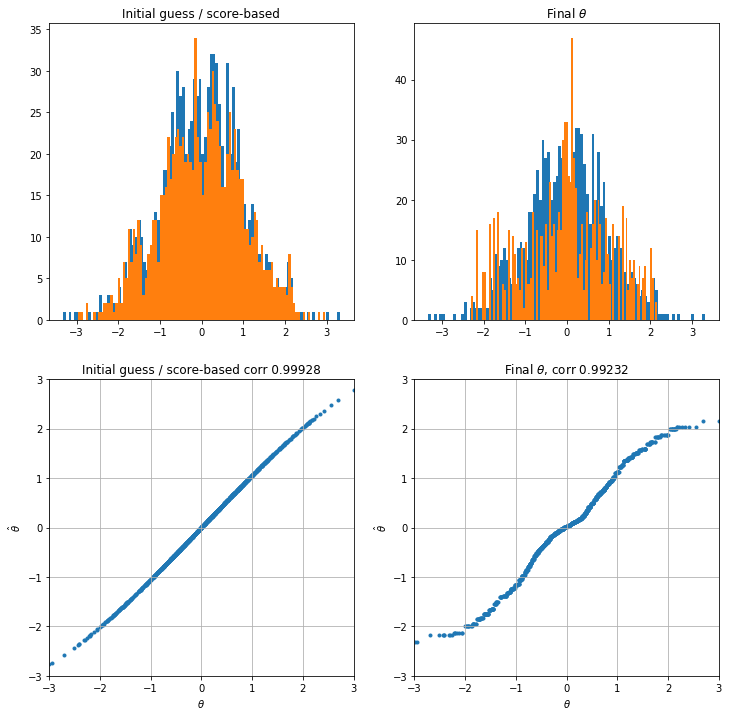

In [37]:
use_logit = True
num_trials = None
dichotomous = False
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination, dichotomous=dichotomous, num_trials=num_trials)
if use_logit:
    model_irf = [lambda t,i=i: logit(nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)) for i in range(I)]
else:
    model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("X range", X.min(), X.max())
print("theta exact mean", np.mean(theta_exact, axis=0), "std", np.std(theta_exact, axis=0))

# Run iterative refinement algorithm.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=2, num_theta_sweeps=0, grid_method="quantile",
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss, alpha=0.0, refine_irf=True, use_logit=False)

t = solver.solve()

theta_init = initial_guess(X, use_logit)
print_run_log(theta_exact, model_irf, theta_init, recorder)
plot_multilevel_irfs(recorder, model_irf)
compare_theta_scatter(theta_exact, theta_init, t)

This does a better job for small and large $\theta$s, but our logit IRFs don't have the right slope of the exact solution, and the $\theta$ distribution is still a bit flattened out.

## Discretized Data
A more challenging case is when the input data is $X_{pi} = Binomial(m, P_i(\theta_p))$ for a finite $n$. So far we tested $X_{pi} = P_i(\theta_p)$, i.e., $m = \infty$. Let's try a smaller $m = 100$. If $X_{pi}=0$, it is set to $1e-8$ and if it is $1$, it is set to $1-1e-8$.

In [102]:
use_logit = False
num_trials = 1
dichotomous = True
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination, dichotomous=True, num_trials=num_trials)
if use_logit:
    model_irf = [lambda t,i=i: logit(nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)) for i in range(I)]
else:
    model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("X range", X.min(), X.max())
print("mean", np.mean(theta_exact, axis=0), "std", np.std(theta_exact, axis=0))

X range 0.0 1.0
mean [-0.004] std [0.976]


In [103]:
# Run iterative refinement algorithm.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=5, num_theta_sweeps=0, grid_method="quantile",
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss, alpha=0.0, refine_irf=True, use_logit=use_logit)

t = solver.solve()

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.7    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.6    	0.00
INFO     5    	7    	19   	1.05   	1.1    	0.2    	0.00
INFO     Total						0.02
INFO     Trimming #neighbors to 5
INFO     Initial guess range [-2.85, 2.82] mean -0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 2 items 8 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at item clustering level with 4 items 16 bins
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving 

INFO     Initial guess / score-based estimation correlation: 0.843
INFO     #items 1
INFO     Initial guess loss 0.0010630
INFO     IRF error: 0.030 +- 0.000	t range -2.849, 2.818 corr 0.842733 loss 0.0010630
INFO     IRF error: 0.006 +- 0.000	t range -2.177, 2.165 corr 0.822350 loss 0.0013610
INFO     IRF error: 0.008 +- 0.000	t range -2.064, 2.127 corr 0.821619 loss 0.0011819
INFO     IRF error: 0.009 +- 0.000	t range -1.998, 2.143 corr 0.820713 loss 0.0011301
INFO     IRF error: 0.010 +- 0.000	t range -1.953, 2.171 corr 0.819908 loss 0.0011118
INFO     #items 2
INFO     Initial guess loss 0.0074325
INFO     IRF error: 0.028 +- 0.003	t range -1.957, 2.272 corr 0.826400 loss 0.0071990
INFO     IRF error: 0.038 +- 0.007	t range -2.079, 2.376 corr 0.821675 loss 0.0051747
INFO     IRF error: 0.050 +- 0.003	t range -2.129, 2.357 corr 0.816908 loss 0.0045505
INFO     IRF error: 0.049 +- 0.000	t range -2.116, 2.261 corr 0.816683 loss 0.0047117
INFO     IRF error: 0.050 +- 0.002	t range -2.0

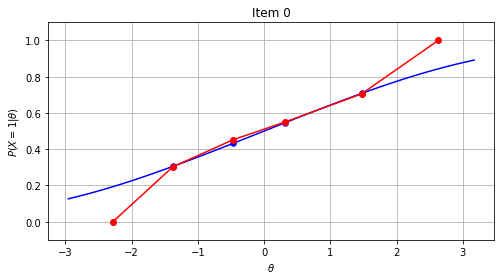

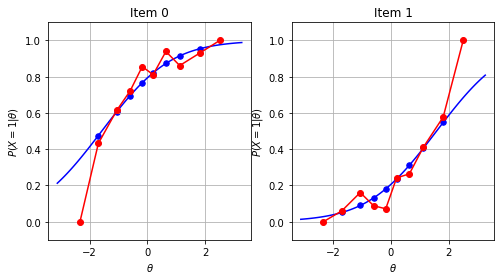

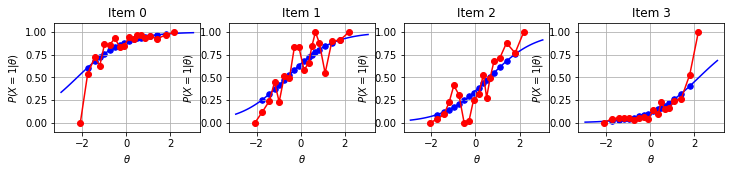

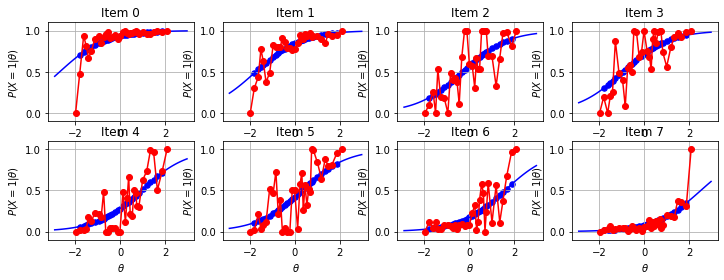

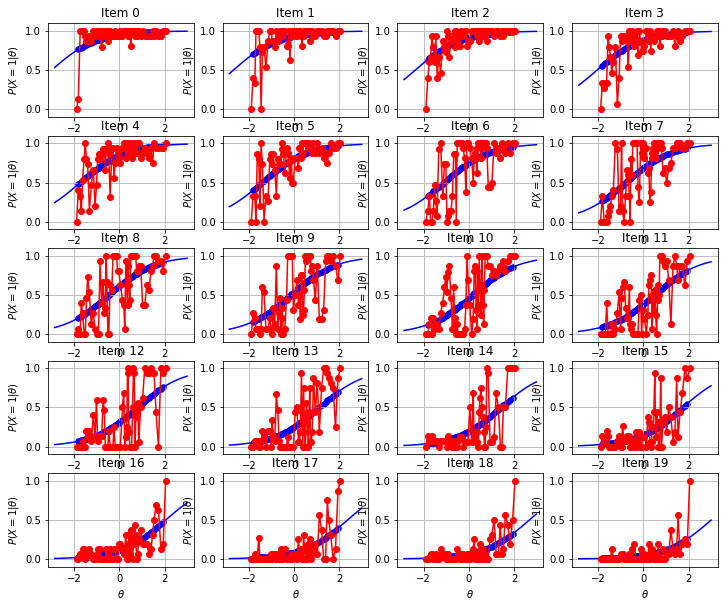

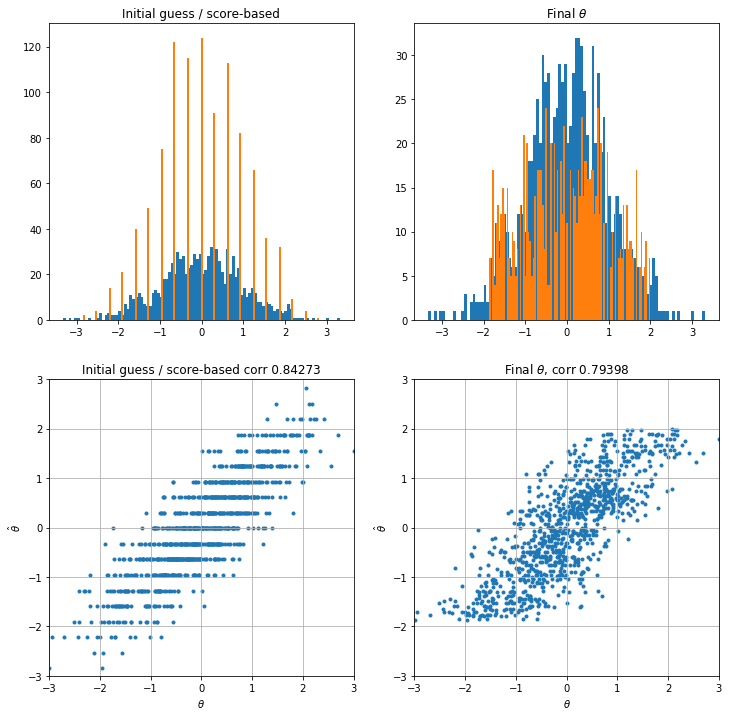

In [107]:
theta_init = initial_guess(X, use_logit)
print_run_log(theta_exact, model_irf, theta_init, recorder)
plot_multilevel_irfs(recorder, model_irf, plot_last=True)
compare_theta_scatter(theta_exact, theta_init, t)

Here the loss is not minimized well (its final value is not less the initial guess at the finest continuation step with $20$ items), and $\theta$s move quite a bit in ordering with respect to the exact distribution.

<!-- ## Non-Rasch Model

$$ P(\theta) = \frac{1}{1 + e^{-a \phi(t - b)}} $$

where $\phi(t)$ is a smooth (and usually monotonic) function of $t$, for instance, $\phi(t) = t^{\beta}$ for odd $\beta$. 2PL is $\beta = 1$.
 
## Extension to multi-dimensional trait
Her ethe value over integration will be shown.

## Extension to binary X
- Cluster students first, determine group $\theta$s, then calculate individual $\theta$s stochastically using MCMC?
-->

## $\theta$ estimate error of $L_2$ loss with exact IRFs

In [41]:
I = 20
P = 100
num_trials = 1
dichotomous = True

# Exact solution.
_, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(
    P, I, C, asymptote=asym, discrimination=discrimination, 
    dichotomous=True, num_trials=num_trials, b_range=(-4, 4))
p_correct = nirt.simulate.simulate_data.three_pl_model(
    theta_exact[:, c], np.ones((I,)) * discrimination, b, 0)
theta_exact = theta_exact[:, 0]
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]

def l2_loss(t, x):
    return sum((model_irf[i](t) - x[i]) ** 2 for i in range(len(x)))

num_experiments = 10
theta_estimate = np.zeros((P, ))
std_err = np.zeros((P, ))

for i in range(num_experiments):
    X = np.random.binomial(num_trials, p=p_correct) / num_trials
    theta_hat = np.array([scipy.optimize.minimize_scalar(
            lambda t: l2_loss(t, X[p]), options={"maxiter": 20}).x
        for p in range(P)])
    theta_estimate += theta_hat
    std_err += (theta_hat - theta_exact) **2
theta_estimate /= num_experiments
std_err = (std_err / num_experiments) **0.5

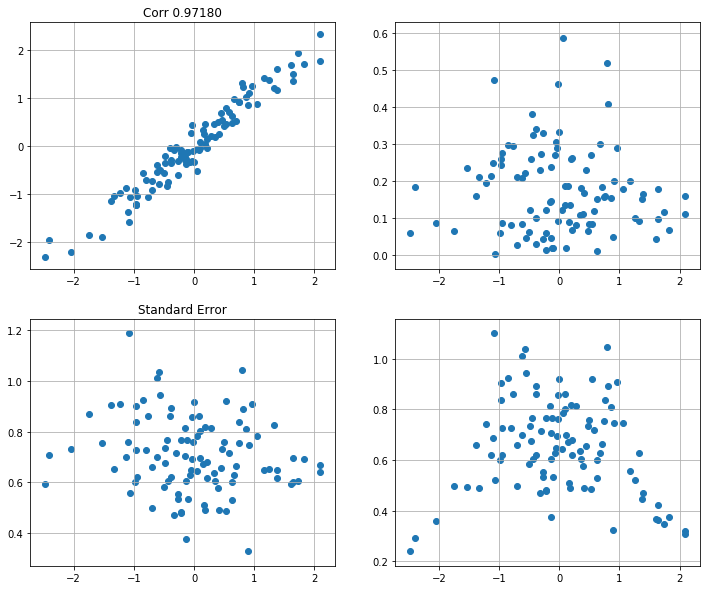

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0, 0]
ax.scatter(theta_exact, theta_estimate)
ax.set_title("Corr {:.5f}".format(np.corrcoef(theta_estimate, theta_exact)[0, 1]))
ax.grid(True);

ax = axs[0, 1]
ax.scatter(theta_exact, np.abs(theta_exact - theta_estimate) / np.clip(np.abs(theta_exact), 1, None))
ax.grid(True);

ax = axs[1, 0]
ax.scatter(theta_exact, std_err)
ax.set_title("Standard Error")
ax.grid(True);

ax = axs[1, 1]
ax.scatter(theta_exact, std_err / np.clip(np.abs(theta_exact), 1, None))
ax.grid(True);

In [43]:
p = np.argmin(theta_exact)
print(p, np.argmin(theta_estimate), theta_exact[p], theta_estimate[p], std_err[p])
print(X[p])
L = lambda t: l2_loss(t, X[p])
scipy.optimize.minimize_scalar(L, options={"maxiter": 20})

44 44 -2.4811681736752327 -2.3279449097387914 0.5941037192380044
[1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


     fun: 1.691297222075235
    nfev: 13
     nit: 8
 success: True
       x: -2.4158136164079975

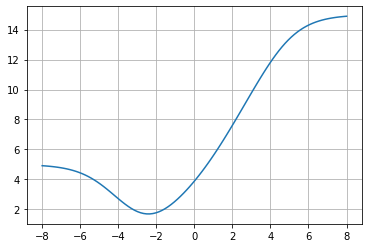

In [90]:
t = np.linspace(-8, 8, 100)
plt.plot(t, L(t))
plt.grid(True);

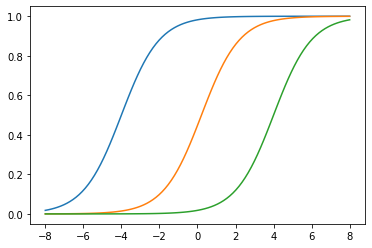

In [91]:
for i in (0, 10, 19): #range(I):
    plt.plot(t, model_irf[i](t))

## Plots for Presentation

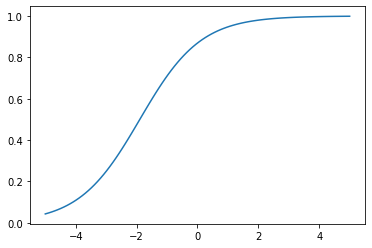

In [48]:
plt.plot(t, model_irf[5](t));

In [61]:
from scipy.interpolate import interp1d
x = np.linspace(-5, 5, num=9, endpoint=True)
y = 1 / (1 + np.exp(-(x - 0.5)))
f = interp1d(x, y)

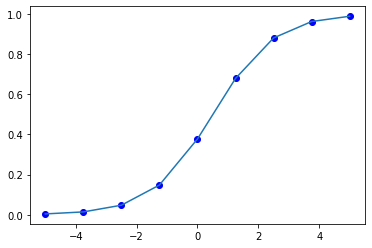

In [65]:
xnew = np.linspace(-5, 5, num=41, endpoint=True)
plt.plot(x, y, 'bo', xnew, f(xnew), '-');

In [59]:
f(xnew)

array([0.004, 0.006, 0.008, 0.009, 0.011, 0.016, 0.02 , 0.025, 0.029, 0.041, 0.053, 0.064, 0.076, 0.103, 0.129, 0.156, 0.182, 0.231, 0.28 , 0.329, 0.378, 0.439, 0.5  , 0.561, 0.622, 0.671, 0.72 , 0.769, 0.818, 0.844, 0.871, 0.897, 0.924, 0.936, 0.947, 0.959, 0.971, 0.975, 0.98 , 0.984, 0.989])

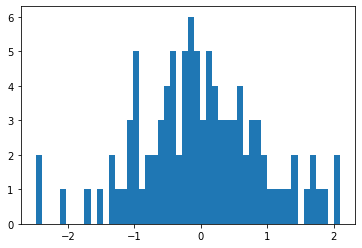

In [70]:
plt.hist(theta_exact, 50);

In [71]:
theta_exact

array([-1.924e-02, -4.820e-02, -1.102e+00, -1.066e+00, -6.410e-02,  6.250e-01,  5.390e-01,  2.093e+00, -2.403e+00,  9.073e-01, -9.855e-01,  2.093e-01,  3.545e-01, -8.555e-01, -1.532e+00,  8.572e-01,  1.048e-01,  1.321e+00, -2.122e-01, -6.970e-01,  3.366e-01,  4.724e-01,  1.648e+00, -2.295e-03,  1.645e+00,  2.078e-01,  8.173e-01, -1.375e+00,  3.938e-01,  1.829e+00, -1.742e+00, -9.694e-01, -2.679e-01, -3.796e-01, -4.745e-01,  1.168e+00,  1.252e+00,  7.531e-01,  1.616e-01, -9.551e-01,  1.752e-01, -5.048e-01, -3.885e-01, -1.189e-01, -2.481e+00,  1.485e-01,  4.917e-01,  1.385e+00,  4.469e-01,  5.245e-01,  7.051e-01,  1.615e+00, -1.221e+00,  4.144e-01, -2.158e-01,  6.284e-01, -4.461e-01,  1.381e+00, -9.613e-01, -3.074e-01, -1.133e+00, -2.039e+00, -4.863e-01,  8.927e-01, -1.040e-01, -7.635e-01, -1.401e-01,  2.095e+00, -5.735e-01,  1.735e+00,  7.489e-01,  1.052e+00, -1.081e+00, -3.934e-01,  5.760e-01, -8.047e-01, -5.579e-01, -3.297e-02, -7.038e-01,  9.653e-01,  2.779e-01, -1.477e-01,
        1

In [76]:
t = np.random.normal(0, 1, size=(10000,))

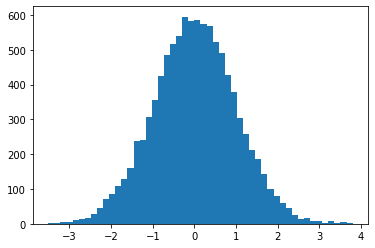

In [77]:
plt.hist(t, 50);

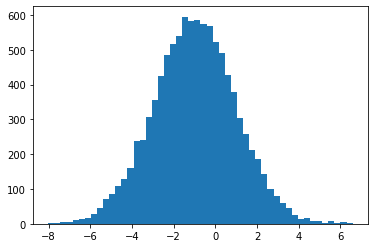

In [78]:
plt.hist(2 * t - 1, 50);

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

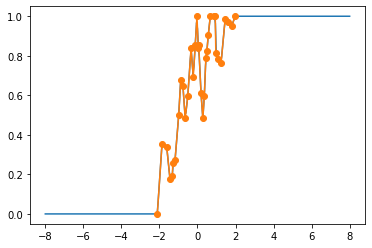

In [86]:
irf = recorder.irf[8][0][5]

# Draw the interpolation nodes (bin centers + extension nodes).
if xlim is None:
    xlim = (-5. 5)
t = np.linspace(xlim[0], xlim[1], 10 * len(self.x) + 1)
ax.plot(t, self.interpolant(t), label=label, color=color)

.plot(plt)